**кластеризатор MeanShift**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.datasets import make_blobs

In [2]:
n_samples = 5000
n_clst = 12 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        centers=n_clst,  
        cluster_std=rng.uniform(size=n_clst)+.7
    )
X.shape

(5000, 2)

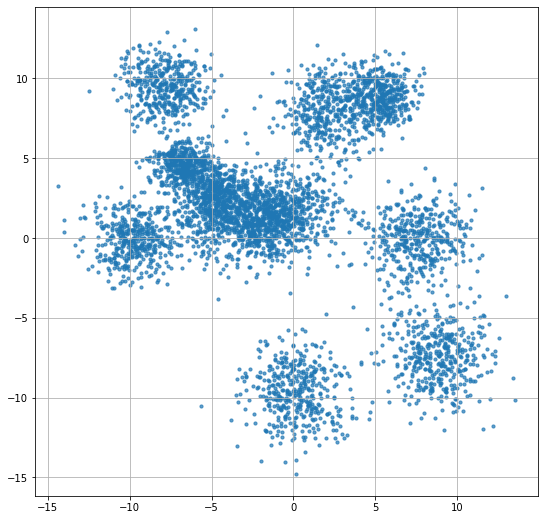

In [3]:
plt.figure(figsize=(9,9))
plt.scatter( x=X[:,0], y=X[:,1], s=10, alpha=0.7 )
plt.grid()

---

In [4]:
# from sklearn.metrics.pairwise import cosine_distances as metric
from sklearn.metrics.pairwise import euclidean_distances as metric

class MeanShift:
    
    def __init__(self,metric=metric,centroid=None):
        self._distance = metric  # метрика, ф-ция расстояния
        self._centroid = [] if (centroid is None) else centroid # центроиды  
        
    def predict(self,X):
        assert len(self._centroid)>0, 'empty centroids, run fit() first'
        return np.argsort(self._distance(X,self._centroid))[:,0] 
    
    def fit(self,X,radius,delta=1e-5): 
        # radius - радиус кластера
        # delta  - минимально допустимый сдвиг центройда
        n_samples = X.shape[0] # количество точек
        idx_free = np.array(range(n_samples)) # номера некластеризированых точек
        n_free = len(idx_free)
        # пока есть некластеризированые точки формируем из них кластеры
        pbar = tqdm(total = n_samples )
        while len(idx_free)>0: 
            idx_free = self._fit(X,idx_free,radius,delta)
            pbar.update(  n_free-len(idx_free) )
            n_free = len(idx_free)
        pbar.close()
        self._centroid = np.vstack(self._centroid)            
        return self
                    
    
    @property
    def centroid(self): return self._centroid

    
    @staticmethod
    def sqe(x1,x2): # квадратичное отклонение
        d=x1-x2
        return d.dot(d.T).flatten()[0]
    
    
    def _fit(self,X,idx_free,radius,delta): 
        # сформировать кластер    
        centroid, idx_cluster = self._build_cluster(X, idx_free.copy(),radius,delta )
        # сохранить центроид и номера точек кластера
        self._centroid.append(centroid) 
        # выкинуть кластеризировнные точки из общего списка необработанных
        return  np.setdiff1d(idx_free,idx_cluster)
    
    
    
    def _build_cluster(self,X,idx_cluster,radius,delta,max_iter=100000):      
        # radius - радиус кластера
        # delta  - минимально допустимый сдвиг центройда
        # idx_cluster = self._idx_free.copy() # кандидаты в кластер
        centroid = X[[rng.choice(idx_cluster)]] # выбираем рандомно точку из некластеризированых как центроид

        for _ in range(max_iter):
            # растояния от центройда до всех точек-кандидатов
            d = self._distance(centroid,X[idx_cluster]) 
            # собираем кластер радиуса r из некластеризированых точек вокруг центроида
            idx_cluster = idx_cluster[ np.where(d<radius)[1] ]
            # пересчитываем центроид
            centroid_old = centroid.copy() 
            centroid = X[ idx_cluster ].mean(axis=0,keepdims=True)
            if self.sqe(centroid_old,centroid)<delta: break

        return centroid, idx_cluster # центроид и номера точек кластера       
    
            

In [5]:
# from sklearn.metrics.pairwise import cosine_distances as distance
# from sklearn.metrics.pairwise import euclidean_distances as distance

cl = MeanShift().fit(X,radius=4.)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 29291.22it/s]


In [6]:
X_centroid = cl.centroid
labels = cl.predict(X)

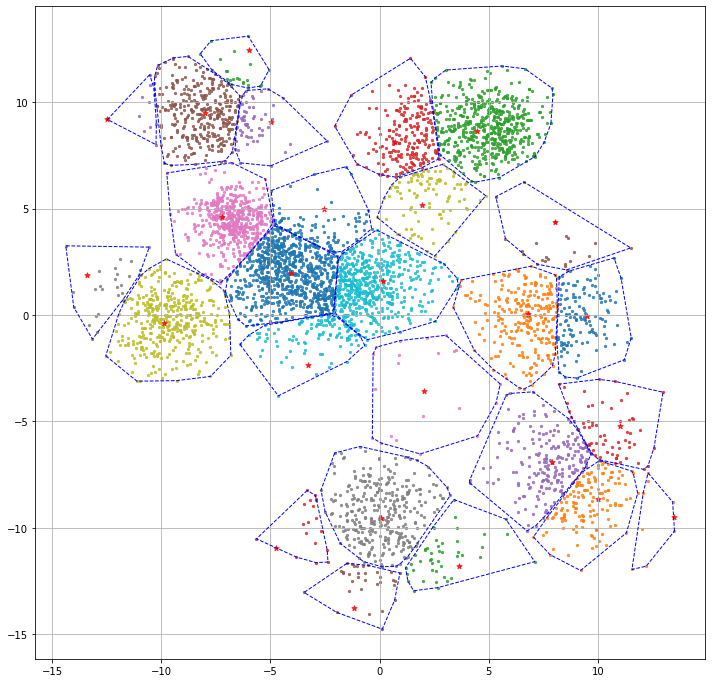

In [7]:
from scipy.spatial import ConvexHull

plt.figure(figsize=(12,12))

for c in np.unique(labels):
    xc = X_centroid[[c]]
    X_ = X[labels==c,:]
    
    if len(X_)<3: # кластеры с очень маленьким числом элементов
        plt.scatter( x=X_[:,0],y=X_[:,1], s=5, alpha=0.8,c='black',marker='+' )    
        plt.scatter( x=xc[:,0],y=xc[:,1], s=30, alpha=0.8,c='black',marker='*' )
    else:
        plt.scatter( x=X_[:,0],y=X_[:,1], s=5, alpha=0.8 )    
        plt.scatter( x=xc[:,0],y=xc[:,1], s=30, alpha=0.8,marker='*',c='r' )
        hull = ConvexHull( X_ ) # рисуем выпуклую оболочку вокруг кластера
        v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
        plt.plot(  X_[v,0],X_[v,1], '--', lw=1,c='b')
    
plt.grid()        